In [1]:
#!git clone https://github.com/chrise96/image-to-coco-json-converter.git

import numpy as np
import os, json, cv2, random, gdown, zipfile, glob, math, shutil
import matplotlib as mpl
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from tqdm import tqdm
from google.colab import files
import glob
from PIL import Image  
from skimage import measure                                # (pip install scikit-image)
from shapely.geometry import Polygon, MultiPolygon         # (pip install Shapely)

In [2]:
from PIL import Image                                      # (pip install Pillow)
import numpy as np                                         # (pip install numpy)
from skimage import measure                                # (pip install scikit-image)
from shapely.geometry import Polygon, MultiPolygon         # (pip install Shapely)
import os
import json

def create_sub_masks(mask_image, width, height):
    # Initialize a dictionary of sub-masks indexed by RGB colors
    sub_masks = {}
    for x in range(width):
        for y in range(height):
            # Get the RGB values of the pixel
            pixel = mask_image.getpixel((x,y))[:3]

            # Check to see if we have created a sub-mask...
            pixel_str = str(pixel)
            sub_mask = sub_masks.get(pixel_str)
            if sub_mask is None:
               # Create a sub-mask (one bit per pixel) and add to the dictionary
                # Note: we add 1 pixel of padding in each direction
                # because the contours module doesn"t handle cases
                # where pixels bleed to the edge of the image
                sub_masks[pixel_str] = Image.new("1", (width+2, height+2))

            # Set the pixel value to 1 (default is 0), accounting for padding
            sub_masks[pixel_str].putpixel((x+1, y+1), 1)

    return sub_masks

def create_sub_mask_annotation(sub_mask):
    # Find contours (boundary lines) around each sub-mask
    # Note: there could be multiple contours if the object
    # is partially occluded. (E.g. an elephant behind a tree)
    contours = measure.find_contours(np.array(sub_mask), 0.5, positive_orientation="low")

    polygons = []
    segmentations = []
    for contour in contours:
        # Flip from (row, col) representation to (x, y)
        # and subtract the padding pixel
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col - 1, row - 1)

        # Make a polygon and simplify it
        poly = Polygon(contour)
        poly = poly.simplify(1.0, preserve_topology=False)
        
        if(poly.is_empty):
            # Go to next iteration, dont save empty values in list
            continue

        polygons.append(poly)

        segmentation = np.array(poly.exterior.coords).ravel().tolist()
        segmentations.append(segmentation)
    
    return polygons, segmentations

def create_category_annotation(category_dict):
    category_list = []

    for key, value in category_dict.items():
        category = {
            "supercategory": key,
            "id": value,
            "name": key
        }
        category_list.append(category)

    return category_list

def create_image_annotation(file_name, width, height, image_id):
    images = {
        "file_name": file_name,
        "height": height,
        "width": width,
        "id": image_id
    }

    return images

def create_annotation_format(polygon, segmentation, image_id, category_id, annotation_id):
    min_x, min_y, max_x, max_y = polygon.bounds
    width = max_x - min_x
    height = max_y - min_y
    bbox = (min_x, min_y, width, height)
    area = polygon.area

    annotation = {
        "segmentation": segmentation,
        "area": area,
        "iscrowd": 0,
        "image_id": image_id,
        "bbox": bbox,
        "category_id": category_id,
        "id": annotation_id
    }

    return annotation

def get_coco_json_format():
    # Standard COCO format 
    coco_format = {
        "info": {},
        "licenses": [],
        "images": [{}],
        "categories": [{}],
        "annotations": [{}]
    }

    return coco_format

# Get "images" and "annotations" info 
def images_annotations_info(maskpath):
    # This id will be automatically increased as we go
    annotation_id = 0
    image_id = 0
    annotations = []
    images = []
    
    for mask_image in glob.glob(maskpath + "*.png"):
        
        # The mask image is *.png but the original image is *.jpg.
        # We make a reference to the original file in the COCO JSON file
        try:
        
          original_file_name = mask_image.replace("label", "rgb").replace("masks", "images")

          # Open the image and (to be sure) we convert it to RGB
          mask_image_open = Image.open(mask_image).convert("RGB")
          w, h = mask_image_open.size
          
          # "images" info 
          image = create_image_annotation(original_file_name, w, h, image_id)
          images.append(image)

          sub_masks = create_sub_masks(mask_image_open, w, h)
          for color, sub_mask in sub_masks.items():
              category_id = category_colors[color]

              # "annotations" info
              
              polygons, segmentations = create_sub_mask_annotation(sub_mask)
              

              # Check if we have classes that are a multipolygon
              if category_id in multipolygon_ids:
                  # Combine the polygons to calculate the bounding box and area
                  multi_poly = MultiPolygon(polygons)
                                  
                  annotation = create_annotation_format(multi_poly, segmentations, image_id, category_id, annotation_id)

                  annotations.append(annotation)
                  annotation_id += 1
              else:
                  for i in range(len(polygons)):
                      # Cleaner to recalculate this variable
                      segmentation = [np.array(polygons[i].exterior.coords).ravel().tolist()]
                      
                      annotation = create_annotation_format(polygons[i], segmentation, image_id, category_id, annotation_id)
                      
                      annotations.append(annotation)
                      annotation_id += 1
          image_id += 1
        except:
            cv2_imshow(cv2.imread(mask_image))
            print(mask_image)
            continue
    return images, annotations, annotation_id




In [3]:
def preprocess_data(source_dir, target_dir):
  os.makedirs(target_dir, exist_ok=True)
  for index, file_name in enumerate(sorted(os.listdir(source_dir))):
    file_src = os.path.join(source_dir, file_name)
    file_dest = os.path.join(target_dir,file_name)

    shutil.copy(file_src, file_dest)

def move_files(source_dir, target_dir, file_names=None):
  if not file_names:
    file_names = os.listdir(source_dir)
      
  for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), os.path.join(target_dir, file_name))

def copy_files(source_dir, target_dir, file_names=None):
  if not file_names:
    file_names = os.listdir(source_dir)
      
  for file_name in file_names:
    shutil.copy(os.path.join(source_dir, file_name), os.path.join(target_dir, file_name))

def delete_files_in_dir(source_dir, except_files=None):
  if not except_files:
    !rm -r $source_dir
    os.makedirs(source_dir, exist_ok=True)
  else:
    file_names = os.listdir(source_dir)
      
    for file_name in file_names:
      if file_name in except_files: continue
      os.remove(os.path.join(source_dir,file_name))

def is_empty(img_path):
  # detects if image is completely black
  image = cv2.imread(img_path)
  return cv2.countNonZero(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)) == 0

def colour2binary(img):
  im_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  im_binary = cv2.threshold(im_gray, 0, 255, cv2.THRESH_BINARY)[1]
  return im_binary


In [4]:
base_dir = "komatsuna"

if not os.path.isdir(base_dir):
  !gdown 1iOVAsyMU7NuBSdNOgbLP24kLi7rHtnZl
  !unzip -q komatsuna.zip


os.makedirs("dataset/images/train", exist_ok=True)
os.makedirs("dataset/images/val", exist_ok=True)
os.makedirs("dataset/images/test", exist_ok=True)

os.makedirs("dataset/masks/train", exist_ok=True)
os.makedirs("dataset/masks/val", exist_ok=True)
os.makedirs("dataset/masks/test", exist_ok=True)



move_files("komatsuna/Bin_0/rgb", "dataset/images/train")
move_files("komatsuna/Bin_0/mask", "dataset/masks/train")

move_files("komatsuna/Bin_1/rgb", "dataset/images/train")
move_files("komatsuna/Bin_1/mask", "dataset/masks/train")

move_files("komatsuna/Bin_2/rgb", "dataset/images/train")
move_files("komatsuna/Bin_2/mask", "dataset/masks/train")

move_files("komatsuna/Bin_3/rgb", "dataset/images/val")
move_files("komatsuna/Bin_3/mask", "dataset/masks/val")

move_files("komatsuna/Bin_4/rgb", "dataset/images/test")
move_files("komatsuna/Bin_4/mask", "dataset/masks/test")


for keyword in ["train", "val","test"]:
  file_dir = "dataset/masks/{}".format(keyword)
  for file_name in os.listdir(file_dir):
    im_path = os.path.join(file_dir, file_name)
    im = cv2.imread(im_path)
    im_binary = colour2binary(im)
    cv2.imwrite(im_path, im_binary)

Downloading...
From: https://drive.google.com/uc?id=1iOVAsyMU7NuBSdNOgbLP24kLi7rHtnZl
To: /content/komatsuna.zip
100% 9.65M/9.65M [00:00<00:00, 46.8MB/s]


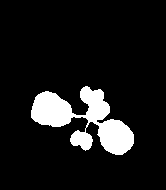

dataset/masks/train/label_01_006_02.png
Created 358 annotations for images in folder: dataset/masks/train/
Created 120 annotations for images in folder: dataset/masks/val/
Created 120 annotations for images in folder: dataset/masks/test/


In [5]:
# Label ids of the dataset
category_ids = {
    "background": 0,
    "plant": 1
}

# Define which colors match which categories in the images
category_colors = {
    "(0, 0, 0)": 0, # Background
    "(255, 255, 255)": 1 # Plant
}

# Define the ids that are a multiplolygon. In our case: wall, roof and sky
multipolygon_ids = [0,1]

if __name__ == "__main__":

    # Get the standard COCO JSON format
    coco_format = get_coco_json_format()
    
    for keyword in ["train", "val", "test"]:
        mask_path = "dataset/masks/{}/".format(keyword)
        
        # Create category section
        coco_format["categories"] = create_category_annotation(category_ids)
    
        # Create images and annotations sections
        
        coco_format["images"], coco_format["annotations"], annotation_cnt = images_annotations_info(mask_path)

        with open("dataset/images/{}/labels.json".format(keyword),"w") as outfile:
            json.dump(coco_format, outfile)
        
        print("Created %d annotations for images in folder: %s" % (annotation_cnt, mask_path))

In [6]:
os.remove("dataset/masks/train/label_01_006_02.png")

In [7]:
delete_files_in_dir("dataset/masks/train")
delete_files_in_dir("dataset/masks/val")
shutil.rmtree("dataset/masks/train")
shutil.rmtree("dataset/masks/val")

In [8]:
!zip -r komatsuna_coco.zip dataset

  adding: dataset/ (stored 0%)
  adding: dataset/masks/ (stored 0%)
  adding: dataset/masks/test/ (stored 0%)
  adding: dataset/masks/test/label_04_006_03.png (deflated 18%)
  adding: dataset/masks/test/label_04_002_03.png (deflated 37%)
  adding: dataset/masks/test/label_04_005_03.png (deflated 20%)
  adding: dataset/masks/test/label_04_005_04.png (deflated 18%)
  adding: dataset/masks/test/label_04_009_02.png (deflated 7%)
  adding: dataset/masks/test/label_04_001_02.png (deflated 40%)
  adding: dataset/masks/test/label_04_007_05.png (deflated 12%)
  adding: dataset/masks/test/label_04_001_01.png (deflated 43%)
  adding: dataset/masks/test/label_04_004_02.png (deflated 27%)
  adding: dataset/masks/test/label_04_003_04.png (deflated 27%)
  adding: dataset/masks/test/label_04_004_04.png (deflated 24%)
  adding: dataset/masks/test/label_04_000_05.png (deflated 45%)
  adding: dataset/masks/test/label_04_002_04.png (deflated 36%)
  adding: dataset/masks/test/label_04_001_03.png (deflated 

In [9]:
files.download("komatsuna_coco.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>